##### 讀入完整資料

In [1]:
# import datetime
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # matplot設定灰背景與白格線
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # matplotlib 顯示中文 (mac os) https://www.code-learner.com/how-to-solve-mac-system-python-matplotlib-library-chinese-gibberish-problem/
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # matplotlib 顯示中文 (windows)
plt.rcParams['axes.unicode_minus'] = False # matplotlib 顯示減號
import numpy as np
import pandas as pd
from datetime import datetime
import os
import warnings
warnings.filterwarnings("ignore")

if not os.path.isdir('LSTM_model'):
        os.mkdir('LSTM_model')

np.random.seed(0)
All = pd.read_csv(f'MERGED_data_onehot/MERGED_ALL.csv') # one-hot版本路徑 MERGED_data_onehot/MERGED_ALL.csv
# All = pd.read_csv(f'MERGED_data_onehot_firework/MERGED_ALL.csv') # 考慮煙火節版本
All['日期'] = pd.to_datetime(All['日期']) # 把日期字串轉為timestamp (timestamp可跟datetime比較)
All.head()

,日期,年份,月份,星期,週末,站名,時段,進站,出站,相鄰站數,...,民族掃墓節,父親節,端午節,聖誕節,萬聖節,補假,補班,西洋情人節,跨年,除夕
0,2017-01-01,2017,1,6,True,BL板橋,0,361,334,3,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-01,2017,1,6,True,BL板橋,1,1,0,3,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-01,2017,1,6,True,BL板橋,6,406,566,3,...,0,0,0,0,0,0,0,0,0,0
3,2017-01-01,2017,1,6,True,BL板橋,7,624,955,3,...,0,0,0,0,0,0,0,0,0,0
4,2017-01-01,2017,1,6,True,BL板橋,8,1062,1063,3,...,0,0,0,0,0,0,0,0,0,0


In [2]:
All.columns

Index(['日期', '年份', '月份', '星期', '週末', '站名', '時段', '進站', '出站', '相鄰站數', '累積確診人數',
       '確診人數', '無經濟防疫新模式', '有經濟防疫新模式', '無二級警戒', '有二級警戒', '無三級警戒', '有三級警戒',
       '無7+7', '有7+7', '無3+4', '有3+4', '無首例確診', '有首例確診', '無口罩實名制', '有口罩實名制',
       '無簡訊實聯制', '有簡訊實聯制', '無Delta變異株', '有Delta變異株', '無Omicron亞型變異株',
       '有Omicron亞型變異株', '一般', '七夕情人節', '中秋節', '元宵節', '元旦', '兒童節', '初一', '初三',
       '初二', '勞動節', '和平紀念日', '國慶日', '母親節', '民族掃墓節', '父親節', '端午節', '聖誕節', '萬聖節',
       '補假', '補班', '西洋情人節', '跨年', '除夕'],
      dtype='object')

##### series_to_supervised()

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Arguments:
		data: 原本的dataframe
		n_in: 要使用先前幾個時步來預測
		n_out: 要預測未來幾個時步
		dropnan: 合併完過去與未來時步後 是否要 drop na
	Returns:
		回傳合併完過去與未來時步的dataframe
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
    
	# 用來訓練的先前時步 (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	
    # 要預測的未來時步 (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
    # concat cols
	agg = pd.concat(cols, axis=1)
	agg.columns = names
    
	# 刪除有 NaN 的 row
	if dropnan:
		agg.dropna(inplace=True)
	return agg

##### reframe() 用來產生含有前幾個時步的dataframe

In [4]:
def reframe(All, station_name, from_date, to_date, flow_type, n_hours, feature_list):
    '''
    argument:
        All - 要 reframe 的 dataframe
        station_name - 站名
        from_date, to_date - 日期區間
        flow_type - 欲探討的人次類型, 進站為'in', 出站為'out', 進加出為'total'
        n_hours - 用前幾個時步去預測 (用前一天預測就設21, 前兩天就設42…etc)
        feature_list - 訓練要用到的特徵
    return:
        reframed - 含有前幾個時步的dataframe
    '''
    # 新欄位'總人次'
    if flow_type == 'total':
        All['人次'] = All['進站'] + All['出站']
    elif flow_type == 'in':
        All['人次'] = All['進站']
    else:
        All['人次'] = All['出站']
    
    # 選定捷運站 與 年份
    df = All[ (All['站名']==station_name) & (All['日期'] >= from_date) & (All['日期'] <= to_date) ]
    
    # 初步篩選特徵 存到 df_part
    df_part = df[feature_list]
    
    # 取出 values 部分 並轉為float32
    values = df_part.values
    values = values.astype('float32')

    reframed = series_to_supervised(values, n_hours, 1, True) # 用前n_hours*天數預測下一小時
    
    return reframed

##### train_test() 切train test

In [5]:
def train_test(reframed, train_set_percentage, n_features):
    '''
    argument:
        reframed - reframed 後的 dataframe, 準備被分成training set與testing set
        train_set_percentage - training set佔總資料的比例
    return:
        train_X, test_X, train_y, test_y
        scaler_1t - 標準化產生的scaler, 之後替 pred_y 與 test_y 做 inverse_transform 的時候需要, 故回傳之
    '''
    train_size = round( reframed.shape[0] * train_set_percentage )
    train = reframed.iloc[:train_size,:]
    test = reframed.iloc[train_size:,:]
    
    # min max scale
    scaler_1t = MinMaxScaler(feature_range=(0, 1))
    scaler_mt = MinMaxScaler(feature_range=(0, 1))

    scaler_1t = scaler_1t.fit(train.iloc[:,-n_features:]) # 一個時步的 scaler, 回傳出去讓 pred_y 跟 test_y 可以 inverse_transform
    scaler_mt = scaler_mt.fit(train) # 多個時步的 scaler, 可以 scale 含有多個時步的 train 與 test
    
    train = scaler_mt.transform(train)
    test = scaler_mt.transform(test)
    
    # var(t-21) ~ var(t-1) 為 train_X 與 test_X 的欄位
    n_X = n_hours * n_features
    train_X = train[:, :n_X]
    test_X = test[:, :n_X]
    
    # var(t) 的最後一欄為 train_y 與 test_y (var(t)的最後一欄是人次, 也就是要預測的目標)
    train_y = train[:, -1]
    test_y = test[:, -1]
    
    # 把 train_X, test_X 都 reshape 成 3-D (資料筆數, 幾個時步, 幾個feature)
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
    
    return [train_X, test_X, train_y, test_y, scaler_1t]

##### 由 All 到產生 train_X, test_X, train_y, test_y

In [15]:
station_name = '台北車站'
from_date = datetime.strptime("2017-01-01", "%Y-%m-%d")
to_date = datetime.strptime("2022-07-31", "%Y-%m-%d")

flow_type = 'in'# in, out, total
n_hours = 21
# feature_list = ['人次']

feature_list = ['月份', '星期', '週末', '時段', '累積確診人數',
       '確診人數', '無經濟防疫新模式', '有經濟防疫新模式', '無二級警戒', '有二級警戒', '無三級警戒', '有三級警戒',
       '無7+7', '有7+7', '無3+4', '有3+4', '無首例確診', '有首例確診', '無口罩實名制', '有口罩實名制',
       '無簡訊實聯制', '有簡訊實聯制', '無Delta變異株', '有Delta變異株', '無Omicron亞型變異株',
       '有Omicron亞型變異株', '一般', '七夕情人節', '中秋節', '元宵節', '元旦', '兒童節', '初一', '初三',
       '初二', '勞動節', '和平紀念日', '國慶日', '母親節', '民族掃墓節', '父親節', '端午節', '聖誕節', '萬聖節',
       '補假', '補班', '西洋情人節', '跨年', '除夕', '人次']

n_features = len(feature_list)
train_set_percentage = 1 - 31/(to_date - from_date).days

reframed = reframe(All, station_name, from_date, to_date, flow_type, n_hours, feature_list) # 丟入 All 產生 reframed, scaler
train_X, test_X, train_y, test_y, scaler = train_test(reframed, train_set_percentage, n_features) # 丟入 reframed 產生 train_X, test_X, train_y, test_y
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)
print(f'{from_date.date()} <-train-> {(from_date + (to_date - from_date) * train_set_percentage).date()} <-test-> {to_date.date()}')

(42140, 21, 50)
(651, 21, 50)
(42140,)
(651,)
2017-01-01 <-train-> 2022-06-30 <-test-> 2022-07-31


##### keras model

In [30]:
units = 128
epochs = 50
bs = 128

model = Sequential()
# model.add(LSTM(units, input_shape=(train_X.shape[1], train_X.shape[2]))) # return_sequences=True
model.add(LSTM(units, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]))) # return_sequences=True
model.add(LSTM(units, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam') # loss='mae' or 'mse'
print(model.summary())
history = model.fit(train_X, train_y, epochs=epochs, batch_size=bs, verbose=1, shuffle=False, validation_data=(test_X, test_y)) # validation_split=0.1, validation_data=(test_X, test_y)
# history = model.fit(train_X, train_y, epochs=epochs, batch_size=bs, verbose=1, shuffle=False, validation_split=0.01) # validation_split=0.1, validation_data=(test_X, test_y)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 21, 128)           91648     
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 223,361
Trainable params: 223,361
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
330/330 [==============================] - 6s 13ms/step - loss: 0.0212 - val_loss: 0.0095
Epoch 2/50
330/330 [==============================] - 4s 11ms/step - loss:

##### 畫出 train loss 與 validtion loss

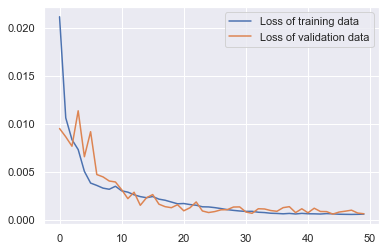

In [31]:
plt.plot(history.history['loss'], label='Loss of training data')
plt.plot(history.history['val_loss'], label='Loss of validation data')
plt.legend()
# plt.savefig('圖/loss.png')
plt.show()

##### Get pred_y after inverse scaling: inverse_pred_y

In [32]:
# 用 model 預測 test_X 產生 pred_y
pred_y = model.predict(test_X)
# 把 test_X 第t時步的部分(var1(t)~var50(t)) 只取feature部分(var1(t)~var49(t))存到 var_t_features
var_t_features = test_X.reshape((test_X.shape[0], n_hours*n_features))[:,-n_features:-1]

# 把 pred_y 合併到 var_t_features 後面, 並使用 scaler.inverse_transform() 逆標準化, 得到 inverse_pred
inverse_pred = np.concatenate( (var_t_features,pred_y), axis=1 )
inverse_pred = scaler.inverse_transform(inverse_pred)

# inverse_pred 的 最後一欄 就是 inverse_pred_y
inverse_pred_y = inverse_pred[:,-1]
inverse_pred_y.shape

(651,)

##### Get test_y after inverse scaling: inverse_test_y

In [33]:
# reshape test_y 由 (xxx,) 變為 (xxx, 1)
test_y = test_y.reshape((len(test_y), 1))

# 把 test_y 合併到 var_t_features 後面, 並使用 scaler.inverse_transform() 逆標準化, 得到 inverse_test
inverse_test = np.concatenate( (var_t_features, test_y), axis=1 )
inverse_test = scaler.inverse_transform(inverse_test)

# inverse_test 的 最後一欄 就是 inverse_test_y
inverse_test_y = inverse_test[:,-1]
# inverse_test_y

##### Print the metrics (RMSE and R2)

In [34]:
rmse = sqrt(mean_squared_error(inverse_test_y, inverse_pred_y))
print(f'RMSE: {rmse:.3f}')

from sklearn.metrics import r2_score
r2 = r2_score(inverse_test_y, inverse_pred_y)
print(f'r2 score: {r2:.3f}')


RMSE: 531.783
r2 score: 0.969


##### Plot the predicted values and true values

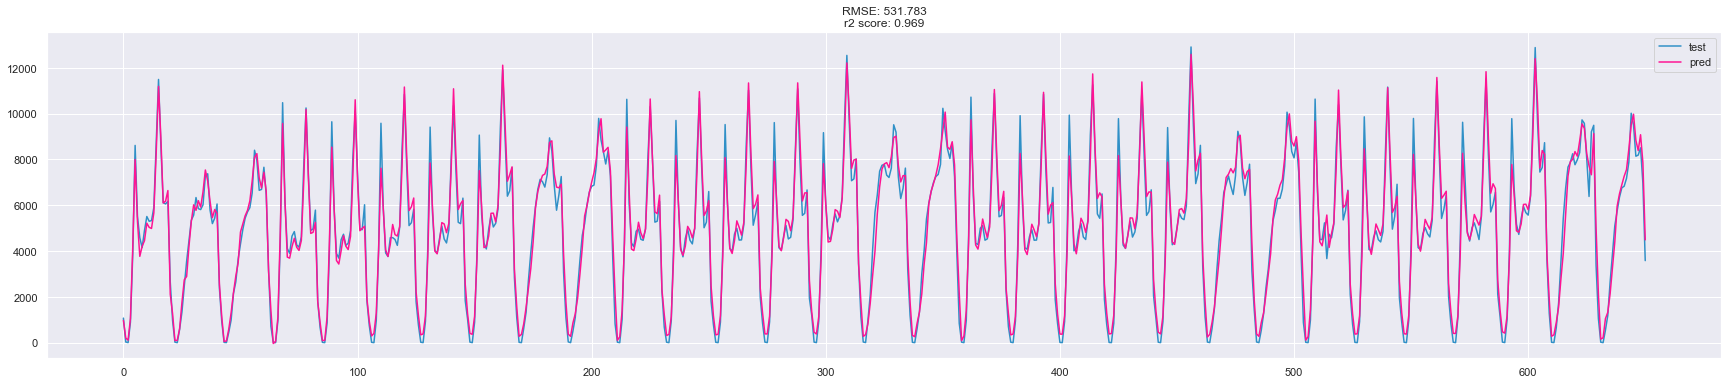

In [35]:
import seaborn as sns; sns.set() # 讓背景變灰, 格線變白
plt.figure(figsize=(30,6))
plt.title(f'RMSE: {rmse:.3f}\nr2 score: {r2:.3f}')
plt.plot(inverse_test_y, label='test',color = '#3090C7');plt.plot(inverse_pred_y, label='pred', color = 'deeppink')
plt.legend()
plt.show()
# np.max(inverse_pred_y)
# np.max(inverse_test_y)

In [36]:
model.save(f'LSTM_model/{station_name}.h5')